Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 07: Compression

## Introduction

This week's sheet should be solved and handed in before the end of **Monday, January 13, 2025**. If you need help (and Google and other resources were not enough), feel free to use the StudIP forum. Please upload your results to your group's Stud.IP folder.

## Assignment 1: Redundancy and compression (5 points)

**a)** Explain in your own words the different types of redundancy mentioned on (CV-08 slide 55). How can you check for each of these types of redundancy?

### Coding Redundancy: Huffman Coding
Huffman coding reduces redundancy by assigning shorter codes to more frequent symbols. It uses variable-length codes to efficiently represent the data.

### Interpixel Redundancy: RLE (Run-Length Encoding)
RLE compresses data by reducing sequences of identical symbols (pixels) into a single value and its count, thus eliminating repeated data.

### Psychovisual Redundancy
Orthogonal transformations (e.g., DCT) separate visually important from unimportant parts of data, enabling more efficient compression by focusing on significant features and discarding less noticeable ones.


**b)** Explain the differences between lossless and lossy compression. Name examples for both of them.

### Lossless compression
Lossless compression reduces file size without any loss of data. The original data can be perfectly reconstructed after compression. (e.g., PNG, ZIP)

### Lossy compression
Lossy compression reduces file size by removing some data, which can result in a loss of quality. The original data cannot be fully recovered. (e.g., JPEG, MP3)


**c)** Compare photos of a scenery to company or product logos that can often be found on websites. Describe their features and explain which type of compression should be used for either.

A **scenery photo** contains complex details and smooth gradients, making it well-suited for **lossy compression** (JPEG). This method efficiently reduces file size while maintaining good image quality, as it discards high-frequency components, which often represent fine details that are not easily noticeable to the human eye.

In contrast a **company logo** often has simple shapes and solid colors, so **lossless compression** (PNG or SVG) is preferred to preserve sharp lines and clear details without any loss.


## Assignment 2: Entropy based compression (8 points)

**a)** Explain the idea of Huffman coding. What is the maximal compression factor that can be achieved for a given image? Load an image and compute that value (you may use `dolly.png` as an example. Make sure to load as 8-bit gray scale image).

Huffman coding is a lossless data compression algorithm that assigns variable-length codes to input symbols based on their frequencies. The most frequent symbols are assigned shorter codes, while less frequent ones are given longer codes. This minimizes the total number of bits required for encoding the data.

Entropy of the image: 7.426579595591898
Compression factor of the image: 1.0772119112206728


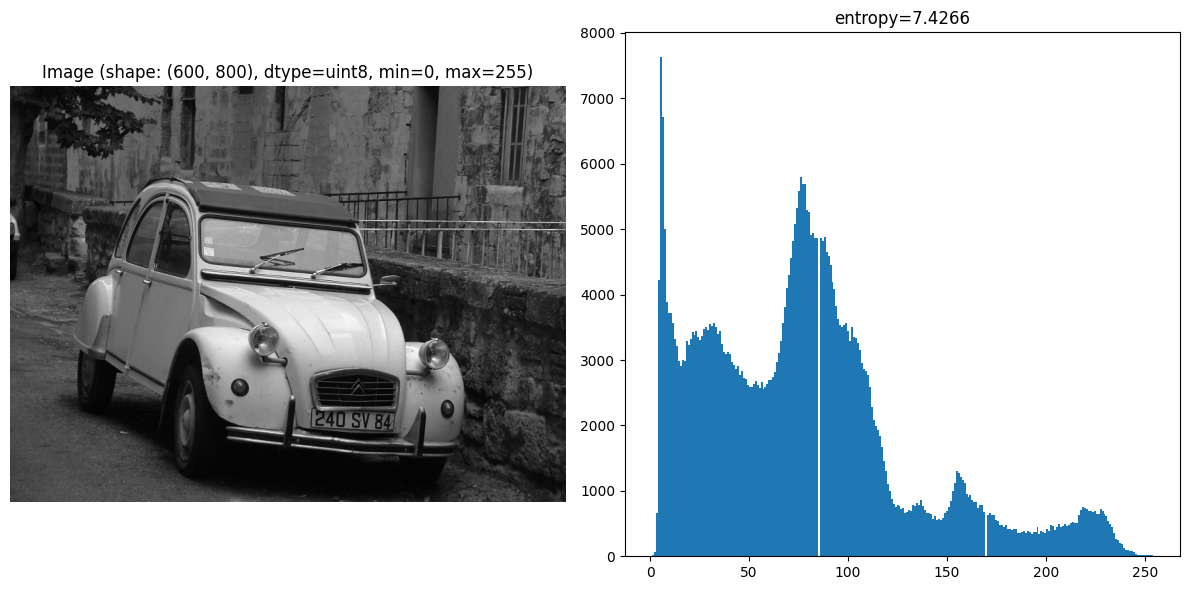

In [1]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')
# Number of pixels in the image
num_pixels = img.size

# Calculate the frequency of each pixel value
pixel_values, counts = np.unique(img, return_counts=True)

# Calculate the probabilities of the pixel values
probabilities = counts / num_pixels

# Calculate the entropy using the given formula
entropy = -np.sum(probabilities * np.log2(probabilities))

# Print the entropy of the image
print(f'Entropy of the image: {entropy}')
compression_factor=8/entropy
print(f'Compression factor of the image: {compression_factor}')
# Plot the image and its histogram
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display the original image on the left
axes[0].imshow(img, cmap='gray')
axes[0].axis('off')  # Remove axis for better visualization
axes[0].set_title(f'Image (shape: {img.shape}, dtype={img.dtype}, min={np.min(img)}, max={np.max(img)})')

# Display the histogram on the right
axes[1].hist(img.ravel(), bins=256, range=(0, 255))
axes[1].set_title(f'entropy={entropy:.4f}')

# Show the plot
plt.tight_layout()
plt.show()


**b)** Now compute the relative frequencies (normalized histogram) of the image and generate an (approximately) balanced tree, as described in (CV-08 slide 33). *Hint:* you may use Python tuples as building blocks of a tree. Every non-leaf node is a pair `(left, right)` where `left` and `right` are the left and right subtrees, respectively (of course you are free to choose another approach if you prefer to do so).

In [2]:
import heapq
hist, bin_edges = np.histogram(img, bins=256, range=(0, 256), density=True)
normalized_histogram = {bin_edges[i]: hist[i] for i in range(len(hist))}
    
sorted_items = sorted(normalized_histogram, key=lambda x: x)

class HuffmanNode:
    def __init__(self, char, freq):
        self.char = char
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq
    
def build_huffman_tree(histogram):
    heap = [HuffmanNode(char, freq) for char, freq in normalized_histogram.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)

        merged = HuffmanNode(None, left.freq + right.freq)
        merged.left = left
        merged.right = right
        
        heapq.heappush(heap, merged)
    
    return heap[0]


In [3]:
tree = build_huffman_tree(sorted_items)
def print_huffman_tree(node, indent=""):
    if node is not None:
        if node.char is not None:
            print(f"{indent}Leaf: {node.char} - Frequency: {node.freq:.4f}")
        else:
            print(f"{indent}Node - Frequency: {node.freq:.4f}")
            print_huffman_tree(node.left, indent + "    ")
            print_huffman_tree(node.right, indent + "    ")
print_huffman_tree(tree)

Node - Frequency: 1.0000
    Node - Frequency: 0.4144
        Node - Frequency: 0.1938
            Node - Frequency: 0.0945
                Node - Frequency: 0.0468
                    Node - Frequency: 0.0232
                        Node - Frequency: 0.0116
                            Leaf: 45.0 - Frequency: 0.0058
                            Node - Frequency: 0.0058
                                Node - Frequency: 0.0029
                                    Leaf: 229.0 - Frequency: 0.0014
                                    Node - Frequency: 0.0014
                                        Leaf: 193.0 - Frequency: 0.0007
                                        Leaf: 235.0 - Frequency: 0.0007
                                Node - Frequency: 0.0029
                                    Leaf: 223.0 - Frequency: 0.0015
                                    Leaf: 150.0 - Frequency: 0.0015
                        Leaf: 75.0 - Frequency: 0.0116
                    Node - Frequency: 0.0236
      

**c)** Now create a prefix free code from this tree, by traversing it following the idea sketched in (CV-08 slide 34). *Hint:* if you used the tuple representation recommended in (b), you can use `isinstance(node, tuple)` to check if `node` is an inner node or a leaf.

In [4]:
# initialize a list of code values
codes = normalized_histogram.copy()
# function to recursively traverse the tree.
# For every inner node assign prefix "0" to the left subtree
# and prefix "1" to the right subtree.
def assign_codes(codes, tree, prefix=''):
    if tree.char is None:  
        codes.update(assign_codes(codes,tree.left, prefix + "0"))  # Traverse left with '0'
        codes.update(assign_codes(codes,tree.right, prefix + "1"))  # Traverse right with '1'
        return codes
    else:  # Leaf node
        return {tree.char: prefix}  # Assign the current prefix to the leaf symbol

assign_codes(codes,tree)
for bit,code in codes.items():
    print( bit,code, normalized_histogram[bit])

0.0 10100011010100001 8.333333333333334e-06
1.0 111110111001011 4.5833333333333334e-05
2.0 1011110100111 0.00014166666666666668
3.0 1111000101 0.0013791666666666666
4.0 1011101 0.008804166666666667
5.0 101010 0.015889583333333332
6.0 011010 0.013983333333333334
7.0 1101111 0.01040625
8.0 1010111 0.008095833333333333
9.0 1010000 0.007752083333333333
10.0 1001111 0.0077395833333333336
11.0 1001100 0.00743125
12.0 0101111 0.00691875
13.0 0100110 0.006689583333333333
14.0 0011010 0.006216666666666666
15.0 0010001 0.0060625
16.0 0011011 0.0062541666666666666
17.0 0011001 0.00620625
18.0 0101100 0.006866666666666667
19.0 0100111 0.006722916666666667
20.0 0101110 0.006910416666666666
21.0 0111010 0.00715625
22.0 0111000 0.0070375
23.0 0111100 0.00718125
24.0 0110010 0.006970833333333333
25.0 0101101 0.0068895833333333335
26.0 0110110 0.007
27.0 0111111 0.007241666666666667
28.0 1000001 0.007295833333333333
29.0 0111110 0.0072208333333333334
30.0 1001000 0.00739375
31.0 1000101 0.0073354166666

**d)** Compute the compression ratio that you can achieve with that code. Compare this with the maximal value computed in part (a). Explain your observation.

In [5]:
acc = 0

def calculate_average_code_length(normalized_histogram, huffman_codes):
    total_length = 0
    for symbol, prob in normalized_histogram.items():
        code_length = len(huffman_codes[symbol])
        total_length += prob * code_length
    return total_length

acc = calculate_average_code_length(normalized_histogram,codes)

print("{:.2f} bits per pixel".format(acc))
print(f"Efficiency: {(entropy / acc) * 100:.2f}%")

7.46 bits per pixel
Efficiency: 99.56%


The compression ratio achieved by Huffman coding is slightly lower than the entropy because Huffman coding, while efficient, is not always optimal. It may result in longer code lengths for certain symbols due to its greedy nature and the fact that code lengths must be integer values, leading to a slight increase in the average bits per pixel.


## Assignment 3: Run length encoding (7 points)


**a)** Explain the idea of *run length encoding*. What are advantages and disadvantages? In what situations should it be applied?

RLE is a simple compression technique where consecutive identical symbols (runs) are replaced with a single symbol and a count of how many times it repeats. For example, the sequence "AAAABBB" would be encoded as "4A3B". 

**Advantages**:
- Efficient for data with long runs of repeated symbols (e.g., simple graphics or monochrome images)
- Easy to implement and fast in both compression and decompression

**Disadvantages**:
- Inefficient for data without many repeated symbols (e.g., highly random data)
- The compressed size can be larger than the original if runs are short or nonexistent

**Best applied**: When the data contains many repeated elements, such as in bitmap images with large areas of uniform color or text with long runs of spaces or characters

**b)** Analyze the run lengths in a gray scale image (8 bit = 256 gray values) by counting the number of runs and the average run length and displaying a histogram of the run lengths. What do you observe? Can you benefit from run length encoding here? (you may use `dolly.png` as an example again, but you may also experiment with other images. Make sure to load it as 8-bit gray scale image).

480000


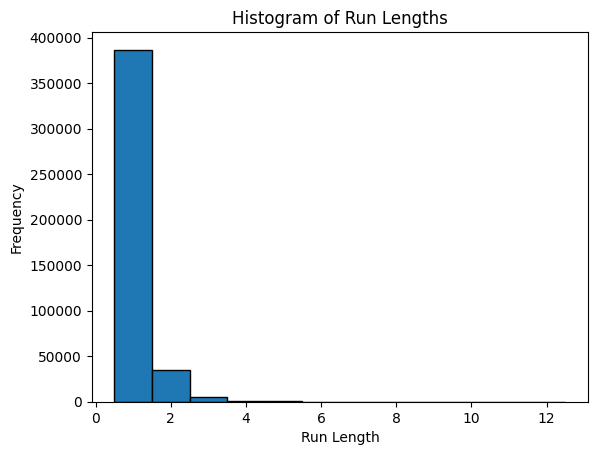

Average Run Length: 1.12


In [6]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

def run_length_encoding(bit_plane):
    rle = []
    for i in range(bit_plane.shape[0]):
        row = []
        prev = bit_plane[i][0]
        count = 1
        for j in range(1, bit_plane.shape[1]):
            if bit_plane[i][j] == prev:
                count += 1
            else:
                row.append((count, prev))
                count = 1
            prev = bit_plane[i][j]
        row.append((count, prev))  # Append the last run
        rle.append(row)
    return rle

rle = run_length_encoding(img)
# Extract run lengths
run_lengths = [length for row in rle for length, _ in row]

# Calculate average run length
average_run_length = np.mean(run_lengths)

print(np.sum(run_lengths))

# Plot histogram of run lengths
plt.hist(run_lengths, bins=range(1, max(run_lengths) + 2), edgecolor='black', align='left')
plt.title("Histogram of Run Lengths")
plt.xlabel("Run Length")
plt.ylabel("Frequency")
plt.show()

# Print average run length
print(f"Average Run Length: {average_run_length:.2f}")
        

**c)** Now consider the individual bit planes. First display the bit planes as in (CV-08 slide 38). What do you observe? Apply your analysis from part (b) to each bitplane.

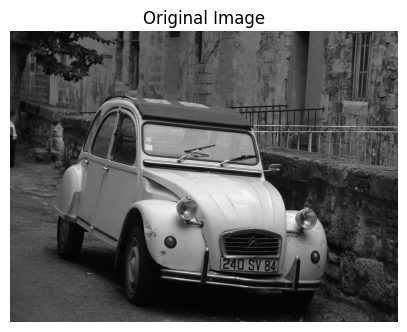

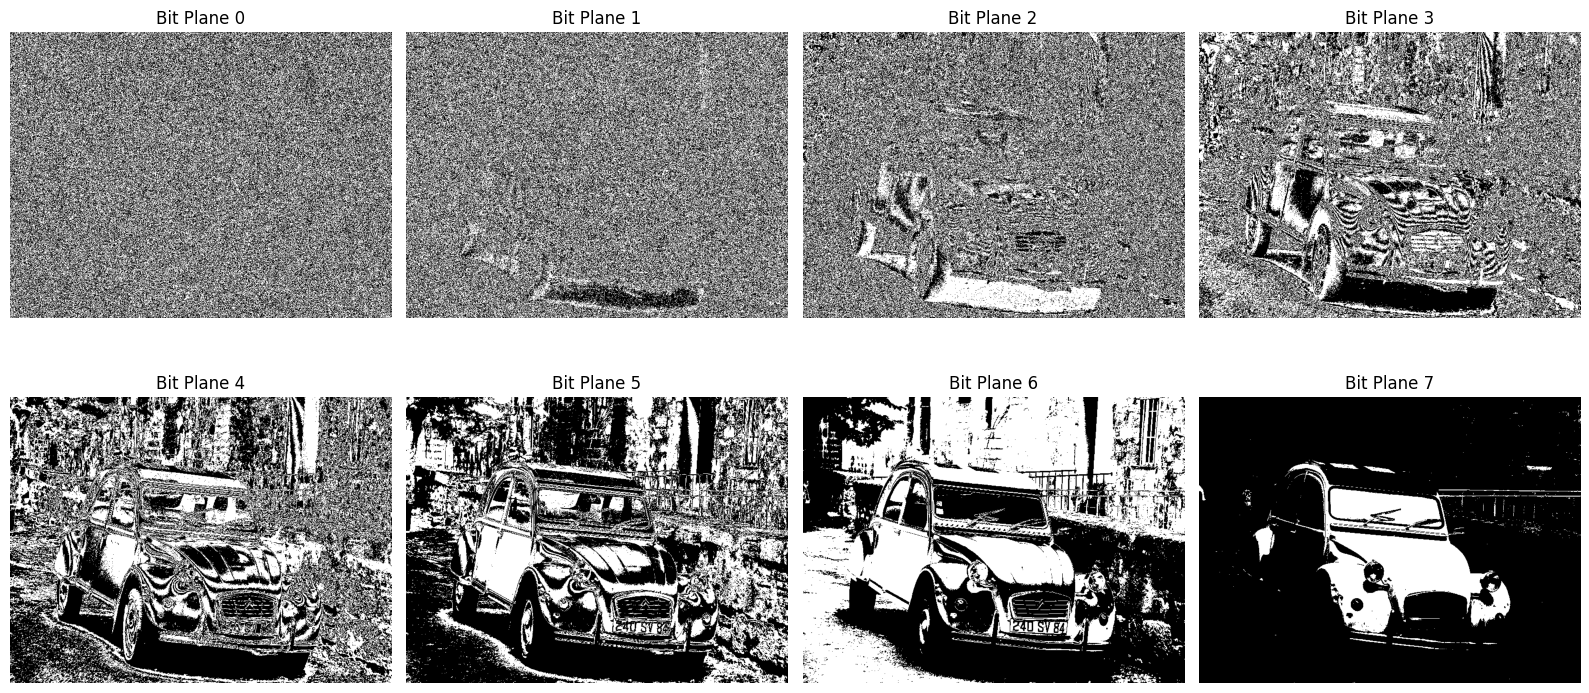

Average Run Length for Bit Plane 0: 2.00
Average Run Length for Bit Plane 1: 2.03
Average Run Length for Bit Plane 2: 2.20
Average Run Length for Bit Plane 3: 2.65
Average Run Length for Bit Plane 4: 3.73
Average Run Length for Bit Plane 5: 6.03
Average Run Length for Bit Plane 6: 12.94
Average Run Length for Bit Plane 7: 70.27


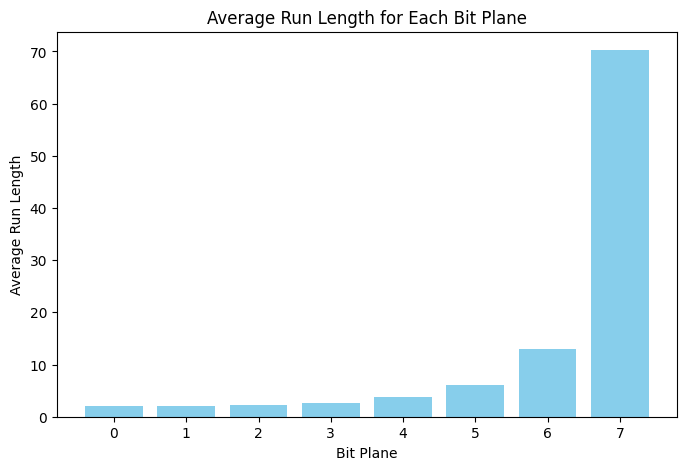

In [7]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

# Load the image in grayscale
img = imageio.imread('images/dolly.png', pilmode='L')

# Display the original image
plt.figure(figsize=(5, 5))
plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.axis("off")
plt.show()

# Extract and display the bit planes
bit_planes = [(img >> i) & 1 for i in range(8)]  # Extract bit planes

# Plot all 8 bit planes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(bit_planes[i], cmap='gray')
    ax.set_title(f"Bit Plane {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# Apply RLE to each bit plane
rle_results = [run_length_encoding(bit_plane) for bit_plane in bit_planes]

# Calculate average run length for each bit plane
avg_run_lengths = []
for i, rle in enumerate(rle_results):
    run_lengths = [length for row in rle for length, _ in row]
    avg_run_length = np.mean(run_lengths)
    avg_run_lengths.append(avg_run_length)
    print(f"Average Run Length for Bit Plane {i}: {avg_run_length:.2f}")

# Plot histogram of average run lengths
plt.figure(figsize=(8, 5))
plt.bar(range(8), avg_run_lengths, color='skyblue')
plt.xlabel("Bit Plane")
plt.ylabel("Average Run Length")
plt.title("Average Run Length for Each Bit Plane")
plt.xticks(range(8))
plt.show()

Bitplane 7 (the most significant bit) has longer run lengths because the values of adjacent pixels are often more stable and homogeneous. Higher bit planes capture more significant features of the image, leading to longer sequences of identical values. In contrast, lower bit planes contain finer details and noise, resulting in shorter run lengths due to more frequent changes in pixel values.


**d)** Explain the idea of the *Gray code*. Why is it better suited for run length encoding? Compute a Gray code for a 256 bit image and recode the image `dolly.png`. Then analyze the run lengths of the individual bit planes of the recoded image.

**Gray code** is a binary numeral system where two successive values differ in only one bit which minimizes the possibility of errors during transitions between values.

Since Gray code ensures that only one bit changes between consecutive values, it results in longer runs of identical bits (either 0s or 1s), which is ideal for RLE. This leads to better compression by exploiting long sequences of the same bit in images, reducing the storage required.


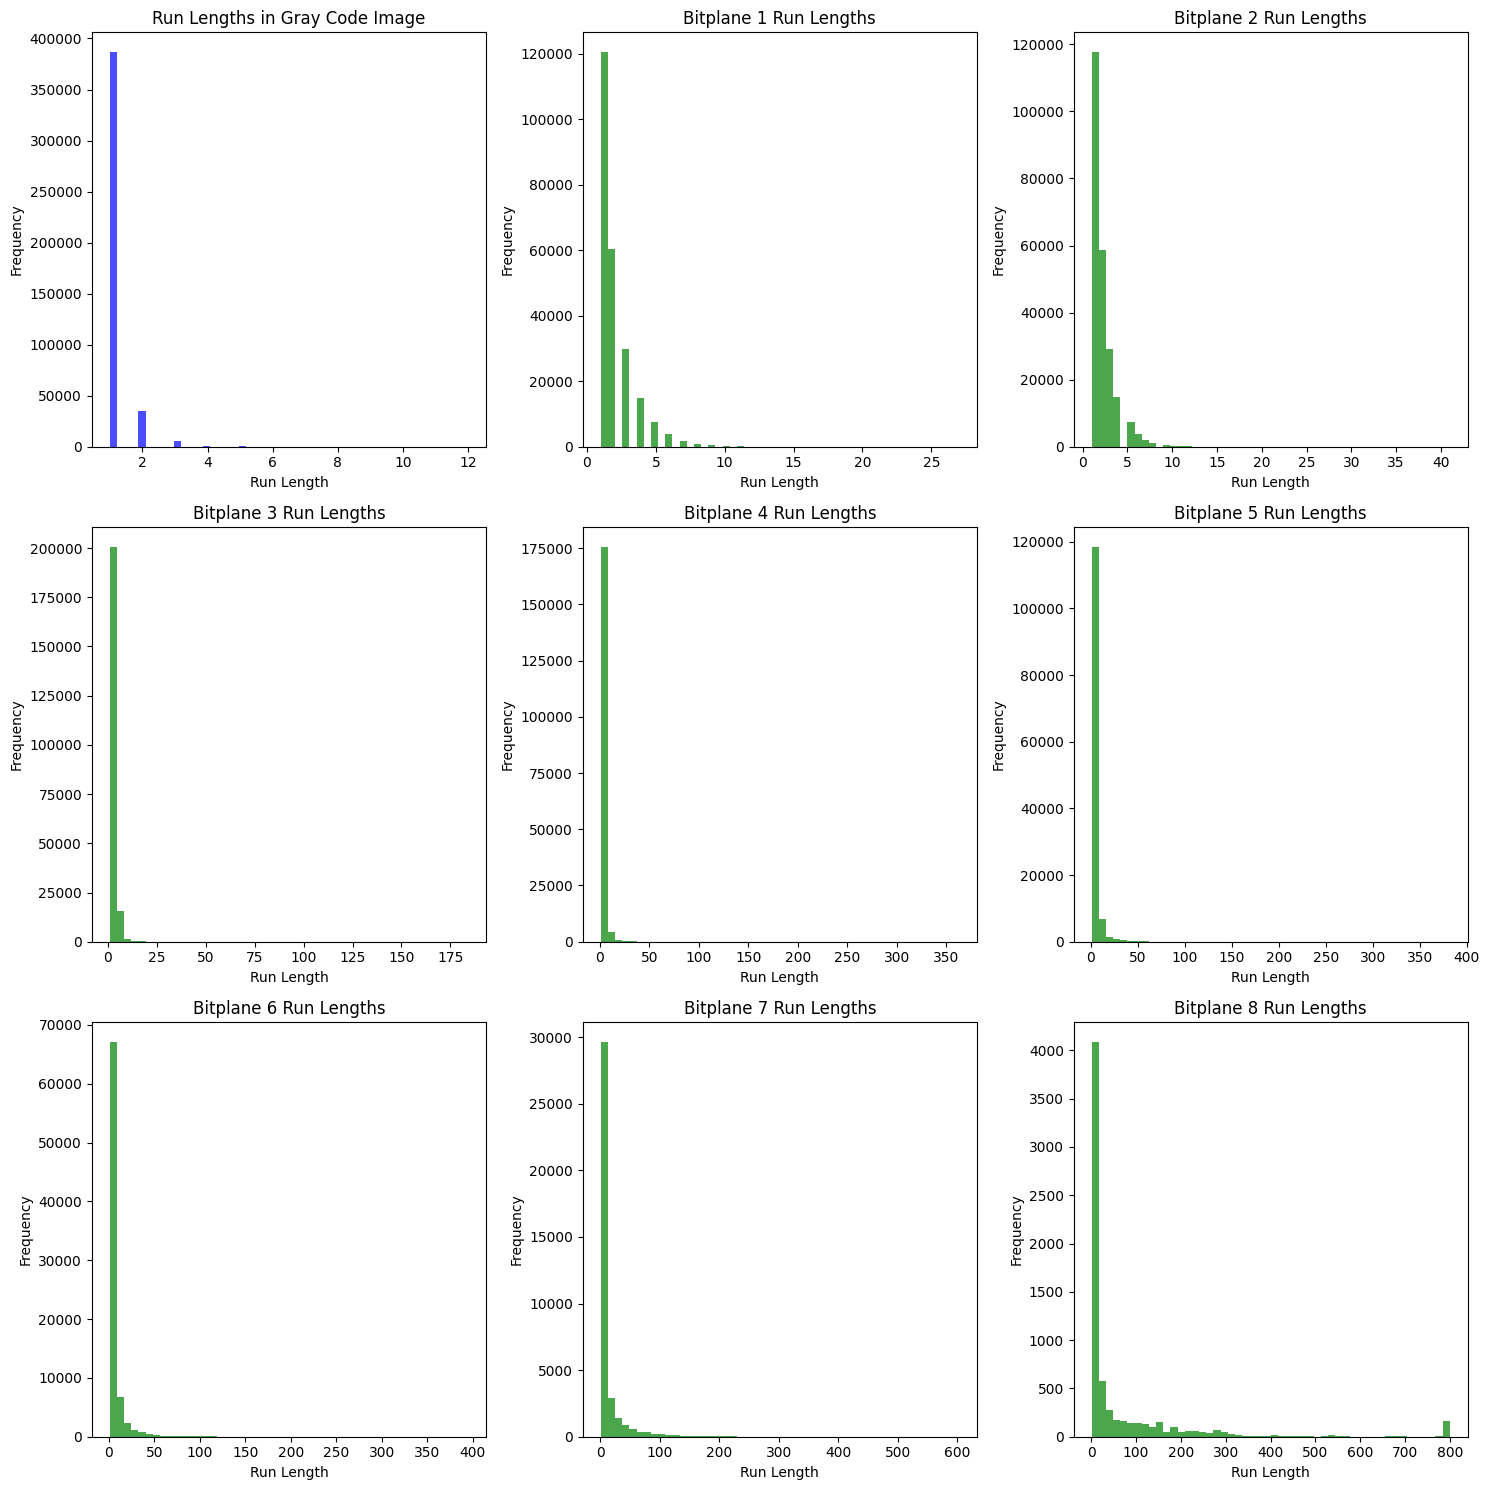

In [8]:
import numpy as np
import imageio.v2 as imageio
import matplotlib.pyplot as plt

img = imageio.imread('images/dolly.png', pilmode='L')

def analyze_run_lengths(image):
    run_lengths = []
    
    # Iterate over rows (you could also iterate over columns if desired)
    for row in image:
        current_value = row[0]
        run_length = 1
        
        # Loop through the row and count runs
        for pixel in row[1:]:
            if pixel == current_value:
                run_length += 1
            else:
                run_lengths.append(run_length)
                current_value = pixel
                run_length = 1
        # Append the last run in the row
        run_lengths.append(run_length)
    
    return run_lengths

# Function to convert a number to its Gray code representation
def to_gray_code(n):
    return n ^ (n >> 1)

# Function to convert an image to Gray code
def convert_to_gray_code(image):
    gray_image = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            gray_image[i, j] = to_gray_code(image[i, j])
    return gray_image

# Convert the image to Gray code
gray_img = convert_to_gray_code(img)
# Extract bit planes from the Gray-coded image
bitplanes = bit_planes = [(img >> i) & 1 for i in range(8)] 


# Analyze the run lengths for the recoded image (Gray code)
run_lengths = analyze_run_lengths(gray_img)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # Create a 3x3 grid for plots

# Plot the run length histogram for the entire Gray-coded image (first plot in grid)
axes[0, 0].hist(run_lengths, bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Run Lengths in Gray Code Image')
axes[0, 0].set_xlabel('Run Length')
axes[0, 0].set_ylabel('Frequency')

# Plot the run length histograms for each bitplane (remaining 8 plots in grid)
for i, bitplane in enumerate(bitplanes):
    run_lengths_bitplane = analyze_run_lengths(bitplane)
    
    row = (i + 1) // 3  # Determine the row in the grid
    col = (i + 1) % 3   # Determine the column in the grid
    
    axes[row, col].hist(run_lengths_bitplane, bins=50, color='green', alpha=0.7)
    axes[row, col].set_title(f'Bitplane {i + 1} Run Lengths')
    axes[row, col].set_xlabel('Run Length')
    axes[row, col].set_ylabel('Frequency')

# Adjust the layout
plt.tight_layout()
plt.show()